
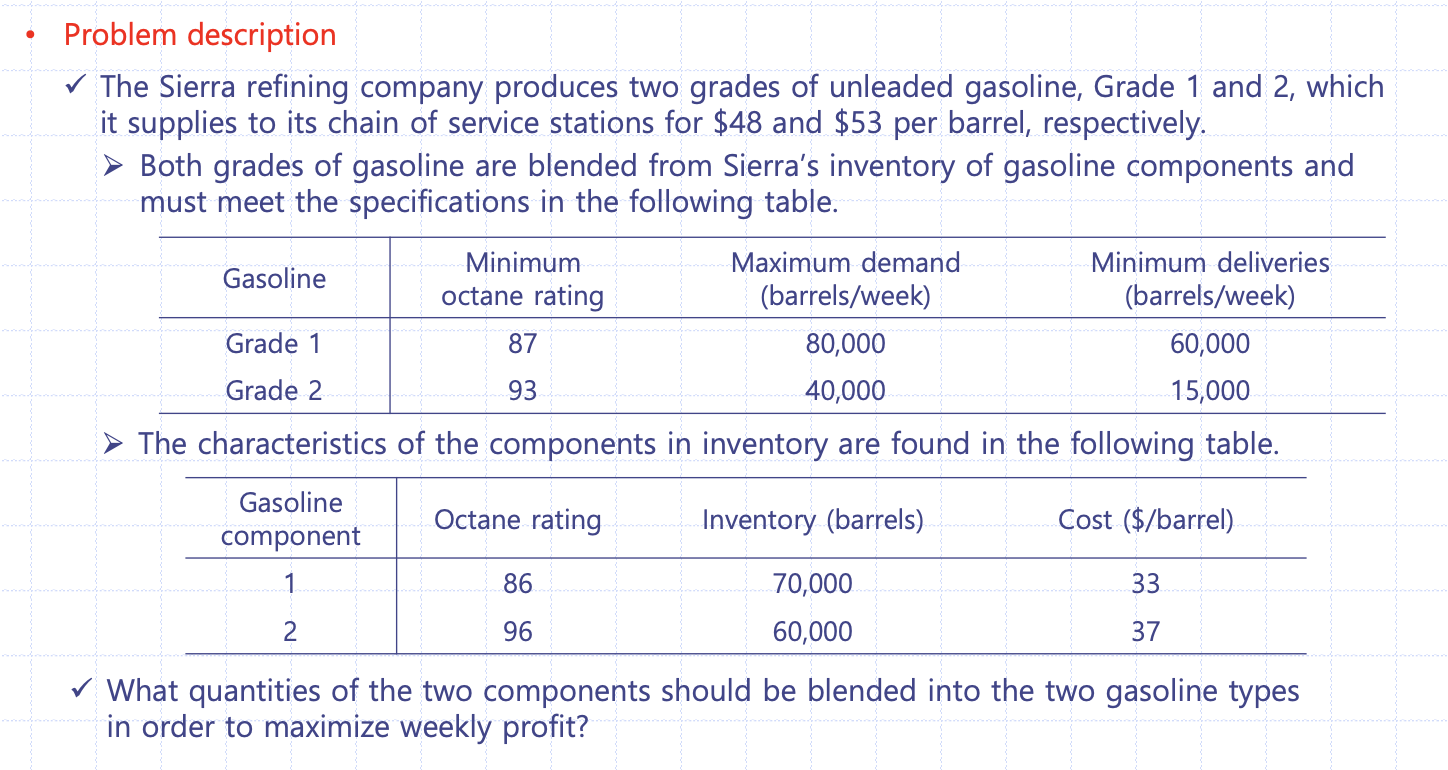

Extracted Math Problem: maximize 4800y_1 + 5300y_2 - 3300x_1 - 3700x_2

subject to

x_1 + x_2 <= 70000  
x_3 + x_4 <= 60000  

x_1 + x_3 = y_1  
x_2 + x_4 = y_2  

86x_1 + 96x_3 >= 87y_1  
86x_2 + 96x_4 >= 93y_2  

60000 <= y_1 <= 80000  
15000 <= y_2 <= 40000  

x_1, x_2, x_3, x_4, y_1, y_2 >= 0
Generated SciPy Code:
 ```python
import numpy as np
from scipy.optimize import linprog

# Objective function: maximize 4800y_1 + 5300y_2 - 3300x_1 - 3700x_2
# Since linprog does minimization, we will negate the objective function for maximization
c = [-4800, -5300, 3300, 3700]  # Coefficients for the objective function
i = 1  # 1 for maximization

# Constraints
# x_1 + x_2 <= 70000
# x_3 + x_4 <= 60000
# x_1 + x_3 = y_1
# x_2 + x_4 = y_2
# 86x_1 + 96x_3 >= 87y_1  -> -86x_1 - 96x_3 <= -87y_1
# 86x_2 + 96x_4 >= 93y_2  -> -86x_2 - 96x_4 <= -93y_2
# 60000 <= y_1 <= 80000
# 15000 <= y_2 <= 40000

# Inequalities in the form Ax <= b
A = [
    [1, 0, 0, 0],      # x_1 + x_2 <= 70000
    [0, 1, 0, 0], 

In [7]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_teddynote.models import MultiModal
from langchain_experimental.tools import PythonREPLTool
from langchain_experimental.utilities import PythonREPL

class LPSolver:
    def __init__(self):
        # Load environment variables
        load_dotenv()
        os.environ["LANGCHAIN_PROJECT"] = "Real World Challenge_LP SOLVER"

        # Initialize models and tools
        self.image_to_code_model = ChatOpenAI(temperature=0, model_name="gpt-4o")
        self.math_to_math_model = ChatOpenAI(temperature=0, model_name="gpt-4o")
        self.math_to_code_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
        self.python_tool = PythonREPL()

        # Initialize system and user prompts
        self.system_prompt = """
            LP 과목의 이해를 돕는 조교야. 주어진 LP 문제 이미지 혹은 문제의 상황을 형식에 맞게 글로 다시 적어줘.
            형식에 대한 예시도 줄게. 예시처럼 적어줘.

            예시 :
            maximize 3x_1 + 2x_2
            subject to
            x_1 + 2x_2 <= 4
            x_1 + x_2 <= 2
            x_1, x_2 >= 0
        """
        self.user_prompt = """
            다음의 문제상황 혹은 LP 문제 이미지를 해당하는 형식에 맞게 LP Formulation 해줘. 
            분, 시간 단위에 유의해서 분으로 단위를 통일해서 적어줘.
            금액은 만원이 아니라 원 단위로 적어줘.
            LaTeX 코드 형식으로 말고 일반 텍스트 형식으로 출력해줘.
        """

    def extract_math_problem(self, image_path: str) -> str:
        multimodal_model = MultiModal(
            self.image_to_code_model,
            system_prompt=self.system_prompt,
            user_prompt=self.user_prompt
        )
        return multimodal_model.invoke(image_path)
    
    def check_math_again(self, math_problem: str) -> str:
        prompt = PromptTemplate.from_template(
            """
            주어진 LP 문제를 standard form으로 다시 작성해줘.
            괄호는 모두 벗겨서 수식으로 적고, 조건식은 우변에 상수만 남게 변수들은 모두 좌변으로 넘겨줘. 조건식의 부등호는 <=이도록 식을 정리해줘.
            """
        )
        chain = prompt | self.math_to_math_model | StrOutputParser()
        return chain.invoke(math_problem)

    def generate_scipy_code(self, problem_description: str) -> str:
        prompt = PromptTemplate.from_template(
            """
            {problem}을 SciPy 라이브러리의 optimize 모듈의 linprog 함수를 사용해서 풀 수 있도록 코드를 만들어.
            문제를 풀기 전에 목점함수가 min문제면 i=0, max문제면 i=1로 값을 할당해줘.
            또 제약 부등식을 코드에 넣기 전에 상수가 있는 우변이 더 크게 가르키도록 변형하고 코드에 넣어줘. 
            그리고 마지막 결과값을 출력할 때 i==0이면 그냥 출력하고, i==1이면 Objective value에 -1을 곱해서 출력해.

            제약 부등식을 부등호의 방향을 기준으로 먼저 구분하여 주석을 작성해.
            그리고 부등호의 방향이 >= 인 것이 있으면 양 변에 -1 을 곱해서 식을 재구성하여
            수정된 제약식을 다시 주석으로 작성해.
            그 뒤에 그 수정된 제약식을 바탕으로 matrix를 알맞게 만들어줘.

            그리고 Optimal Solution도 출력해줘.
            바로 실행할 수 있도록 코드만 적어줘.

            결과 출력은 아래의 형태로 해줘.

            If the solution is infeasible, then print out with 'print("It is infeasible")'.
            If the solution is unbounded, then print out with 'print("It is unbounded")'.
            """
        )
        chain = prompt | self.math_to_code_model | StrOutputParser()
        return chain.invoke({"problem": problem_description})

    def execute_code(self, code: str) -> str:
        try:
            return self.python_tool.run(code)
        except Exception as e:
            return f"Failed to execute.\nCode: {code}\nError: {type(e).__name__} - {e}"

    def solve_lp_problem(self, image_path: str) -> str:
        # Step 1: Extract math problem from image
        math_problem = self.extract_math_problem(image_path)
        print("Extracted Math Problem:", math_problem)

        # Step 2:  Check the problem again to suit the code
        check_math_again = self.check_math_again(math_problem)
        print("Standard Form: \n", check_math_again)


        # Step 3: Generate Python code for solving the problem
        scipy_code = self.generate_scipy_code(check_math_again)
        print("Generated SciPy Code:\n", scipy_code)

        # Step 3: Execute the generated code
        result = self.execute_code(scipy_code)
        print("Execution Result:", result)

        return result

if __name__ == "__main__":
    IMAGE_PATH = "/Users/user/Documents/GitHub/RWC_LP/problem_set/22.png"
    solver = LPSolver()
    solver.solve_lp_problem(IMAGE_PATH)
